In [1]:
import torch
from torch import nn
from torch.utils import data
from torch.nn.utils import clip_grad_norm_
from torchvision import transforms
import os
from astropy.visualization import MinMaxInterval, AsinhStretch 
from astropy.io import fits
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
from PIL import Image
from tqdm import tqdm

In [2]:
dict_encode = {'quasar': 0, 'star': 1, 'galaxy': 2}

class FITSDataset(data.Dataset):
    def __init__(self, data_path, transforms):
        self.img_files = list(Path(data_path).glob("*/*.fits"))
        self.transforms = transforms

    def __getitem__(self, index):
        _img = fits.getdata(self.img_files[index]).astype(np.float32)
        _label = dict_encode[self.img_files[index].parent.name]

        if self.transforms is not None:
            return self.transforms(_img), _label

        else:
            return _img, _label

    def __len__(self):
        return len(self.img_files)

def ToImage(arr):
    return Image.fromarray(arr)

def Norm(img):
    norm_tr = AsinhStretch() + MinMaxInterval()
    return norm_tr(img)

fits_transform = transforms.Compose([
    transforms.Lambda(ToImage),
    transforms.Resize(size=(32, 32)),
    transforms.Lambda(Norm),
    transforms.ToTensor()
])

BATCH_SIZE = 256

train_dataset = FITSDataset("/home/dialup/projects/astroML/data/training_set/", fits_transform)
train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)

test_dataset = FITSDataset("/home/dialup/projects/astroML/data/testing_set/", fits_transform)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

print(f"{len(train_dataloader)} train batches of {BATCH_SIZE} and {len(test_dataloader)} test batches of {BATCH_SIZE}")

# _data_tensor, _label_tensor = next(iter(train_dataloader))

# plt.imshow(_data_tensor[0].squeeze().numpy(), cmap='gray')
# plt.title(f"Class: {_label_tensor.numpy()[0]}");

173 train batches of 256 and 74 test batches of 256


In [3]:
torch.manual_seed(42)

class VGG16(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        return self.fc2(
                self.fc1(
                self.fc(
                self.layer13(
                self.layer12(
                self.layer11(
                self.layer10(
                self.layer9(
                self.layer8(
                self.layer7(
                self.layer6(
                self.layer5(
                self.layer4(
                self.layer3(
                self.layer2(
                self.layer1(x)
                )))))))))))))))
        

In [ ]:
EPOCHS = 9
LR = 0.001
# WD = 0.0
MAX_NORM = 2.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGG16().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RAdam(params=model.parameters(), lr=LR)

train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in tqdm(range(EPOCHS)):
    model.train()

    train_loss.append(0.)
    train_acc.append(0.)

    for (imgs, labels) in train_dataloader:
        imgs, labels = imgs.to(device=device, non_blocking=True), labels.to(device=device, non_blocking=True)
        
        logits = model(imgs)
        loss = criterion(logits, labels)
        train_loss[-1] += loss.item()

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        pred_classes = torch.argmax(torch.softmax(logits, dim=1), dim=1)
        train_acc[-1] += (pred_classes==labels).sum().item() / len(logits)
    
    train_loss[-1] /= len(train_dataloader)
    train_acc[-1] /= len(train_dataloader)
    
    test_loss.append(0.)
    test_acc.append(0.)

    model.eval()
    with torch.inference_mode():
        for (imgs, labels) in test_dataloader:
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device=device, non_blocking=True)

            logits = model(imgs)
            loss = criterion(logits, labels)
            test_loss[-1] += loss.item()

            pred_classes = torch.argmax(torch.softmax(logits, dim=1), dim=1)
            test_acc[-1] += (pred_classes==labels).sum().item() / len(logits)
        
        test_loss[-1] /= len(test_dataloader)
        test_acc[-1] /= len(test_dataloader)

    clip_grad_norm_(parameters=model.parameters(), 
                    max_norm=MAX_NORM, 
                    norm_type=2)


100%|██████████| 9/9 [44:32<00:00, 296.97s/it]


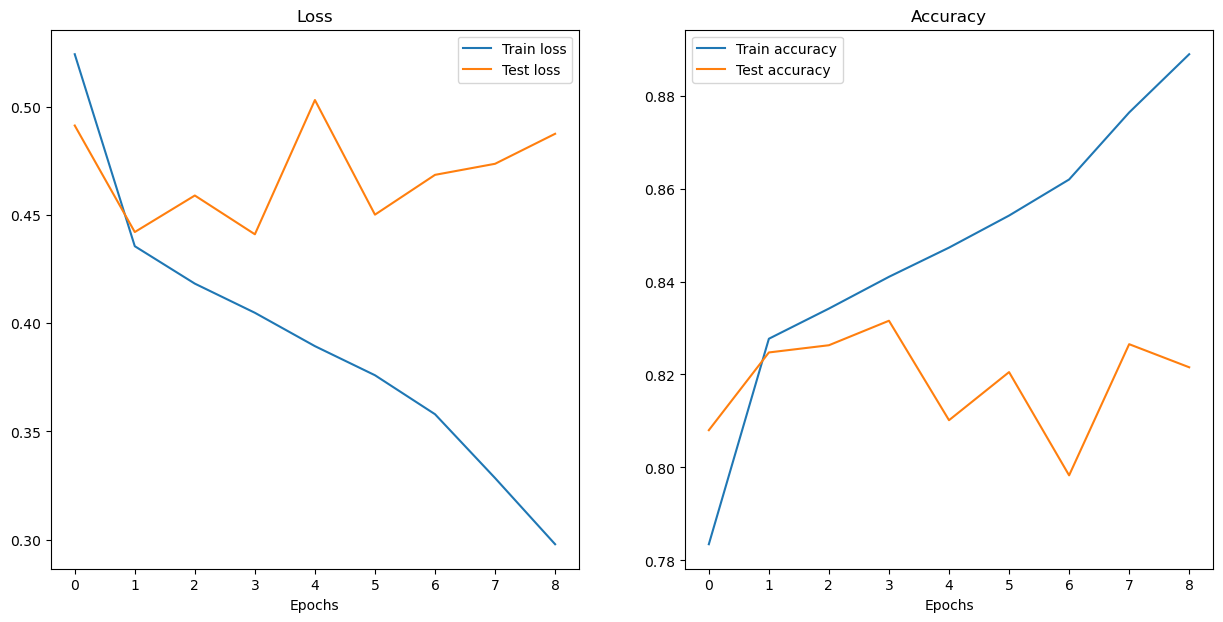

In [7]:
plt.figure(figsize=(15, 7))

epoch_range = range(EPOCHS)

plt.subplot(1, 2, 1)
plt.plot(epoch_range, train_loss, label="Train loss")
plt.plot(epoch_range, test_loss, label="Test loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_range, train_acc, label="Train accuracy")
plt.plot(epoch_range, test_acc, label="Test accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend();

In [73]:
MODEL_NAME = f"vgg16-{LR:.4f}-{int(MAX_NORM)}-{EPOCHS}.pth".replace('.', '_', 1)
MODEL_FILEPATH = os.path.join("models", MODEL_NAME)
torch.save(obj=model.state_dict(), f=MODEL_FILEPATH)